In [1]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec

import scipy
import scipy.constants
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import shapiro

import random

import data_util as util


In [104]:
'''Pull in data'''


E_BIND = 14
sim_len = 100
data_loc = "25mil"
name_len = ""  # some of the file names have how long it is. should be of the format _xmil where x is a num


# Constant params
first_tstep = 10000
last_tstep = sim_len*1000000+10000
tstep_size = 5000
# coords.dmp
dmp = "../sims_out/ebind/%s/ebind%d%s/coords.dmp" % (data_loc, E_BIND, name_len)
coords_dat = "out/ebind%d/coords.dat" % E_BIND
tot_lns = sim_len*2*1000+11
lns_per_time = 10
bad_lns = 9
tsteps_on = True
coords_cols = {
    0: "c_coords"
}
# log.lammps
thermo = "../sims_out/ebind/%s/ebind%d%s/log.lammps" % (data_loc, E_BIND, name_len)
thermo_dat = "out/ebind%d/thermo.dat" % E_BIND
thermo_cols = {  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",  
    #5: "Press"
}

# Varying params
if data_loc == "25mil" or data_loc == "extended": # normal
    last_ln = sim_len*2*100+266 - 32
    tot_len = sim_len*2*100+266
elif data_loc == "5mil":  # result of 5mils being old code
    header_len = 229
    last_ln = 1230
    tot_len = 1262

if data_loc == "25mil":
    header_len = 246
if data_loc == "extended":
    header_len = 233

    
coords_data = util.dmp_to_dat(dmp, coords_dat, tot_lns, lns_per_time, bad_lns, coords_cols, tsteps_on=tsteps_on, first_tstep=
                         first_tstep, last_tstep=last_tstep, tstep_size=tstep_size)
thermo_data = util.thermo_to_dat(thermo, thermo_dat, header_len, last_ln, tot_len, thermo_cols, first_tstep, last_tstep, 
                                 tstep_size)
#Hacky -- lazy, so just converting these to dictionaries since everything was written for this
# Convert to dictionary of numpy arrays:
thermo_data = thermo_data.to_dict("series")
for key in thermo_data:
    thermo_data[key] = np.array(thermo_data[key].values)
coords_data = coords_data.to_dict("series")
for key in coords_data:
    coords_data[key] = np.array(coords_data[key].values)

# Reduce size
reduce_size = False
div = 8
if reduce_size:
    for key in thermo_data:
        og_array = thermo_data[key]
        new_list = []
        for idx, element in enumerate(og_array):
                if idx % div == 0:
                    new_list.append(element)

        thermo_data[key] = np.array(new_list)
    for key in coords_data:
        og_array = coords_data[key]
        new_list = []
        for idx, element in enumerate(og_array):
                if idx % div == 0:
                    new_list.append(element)

        coords_data[key] = np.array(new_list)

print("Number of timesteps: ", len(thermo_data["timestep"]))


Number of timesteps:  5001


SPACER

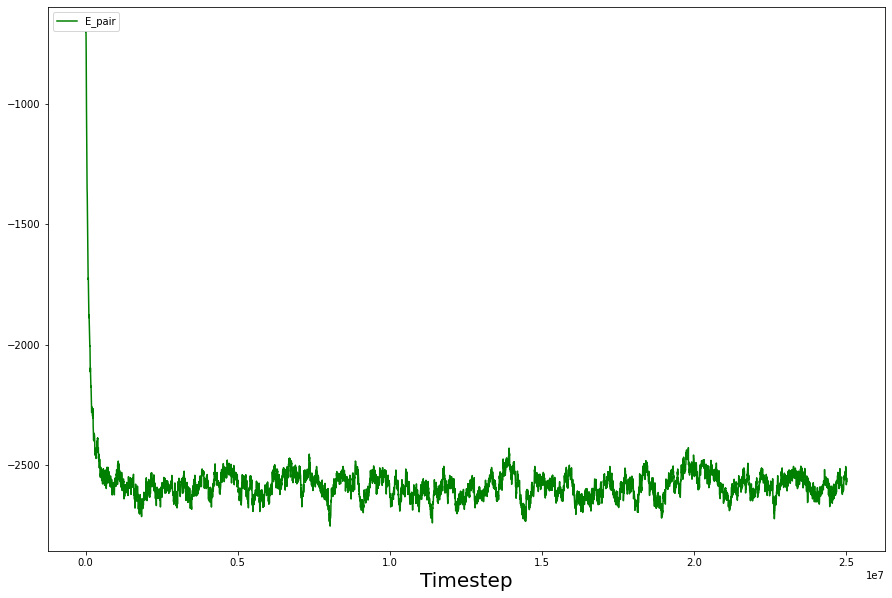

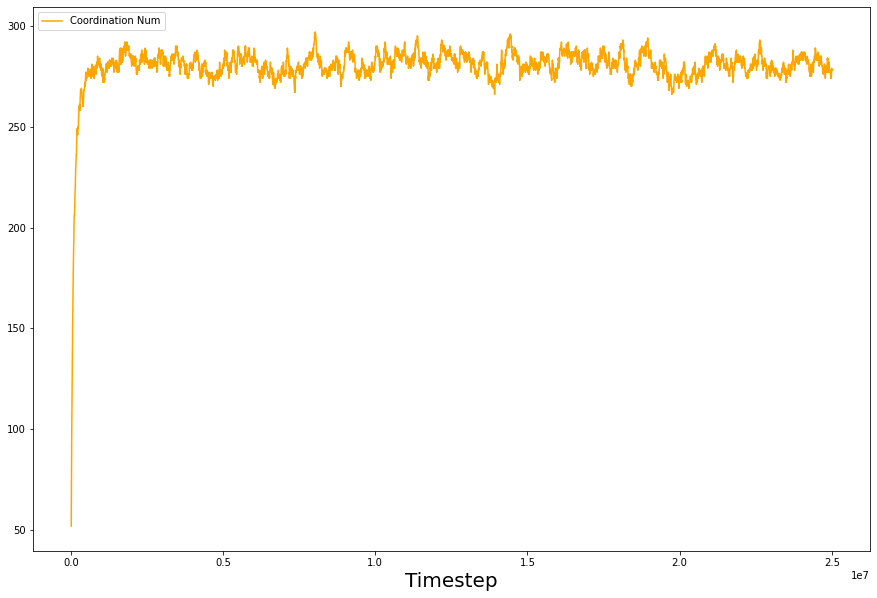

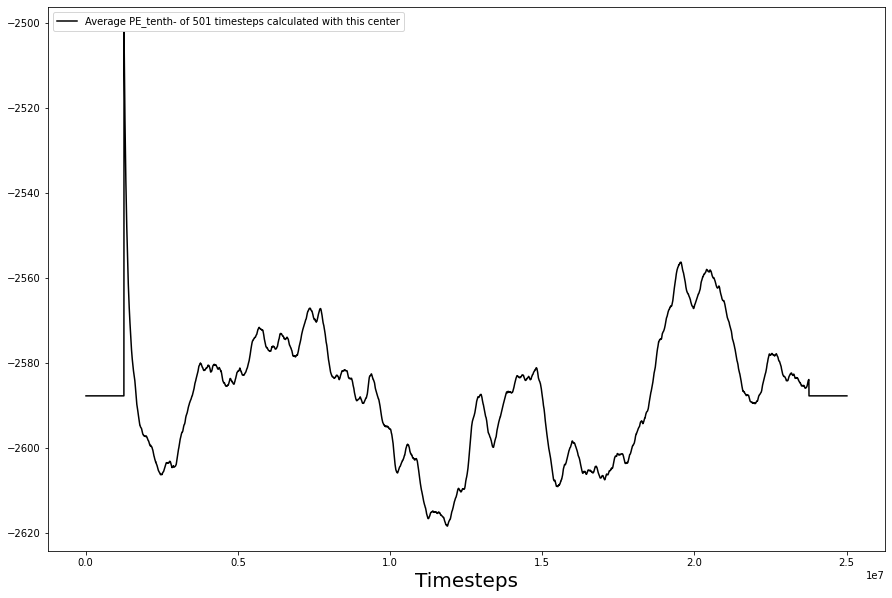

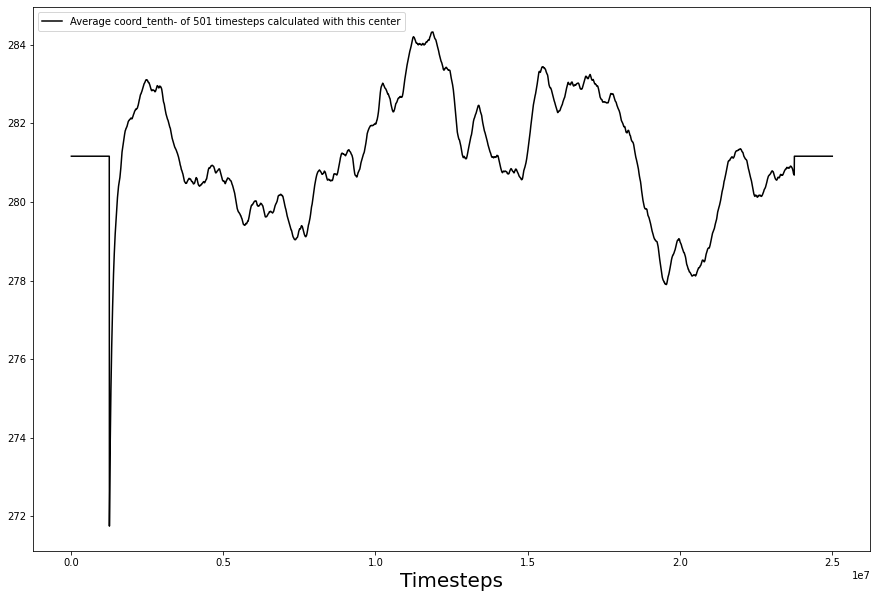

In [105]:
### STEP 1: TEST IF EQ HAPPENS
'''Leg 1: Visual Inspection'''


block_width = (len(thermo_data["timestep"])-1)/10 + 1
thermo_on = False
avg_end_on = False

timesteps = thermo_data["timestep"]
pe = thermo_data["E_pair"]
coord = coords_data["c_coords"]
assert len(pe) == len(coord) and len(coord) == len(timesteps)
steps = [i for i in range(len(pe))]

# Make plots
# Basic plots
# Plot thermo data
if thermo_on:
    fig, ax = plt.subplots(figsize=[15, 10])
    #ax.plot(timesteps, thermo_data["Press"], label="Pressure", color="red", linestyle="solid")
    # BUG: press column contains "e-05", which pd.fwf won't read. so canceling press for now
    ax.plot(timesteps, thermo_data["Temp"], label="Temperature", color="orange", linestyle="solid")
    ax.plot(timesteps, thermo_data["E_pair"], label="E_pair", color="green", linestyle="solid")
    ax.plot(timesteps, thermo_data["E_mol"], label="E_mol", color="blue", linestyle="solid")
    ax.plot(timesteps, thermo_data["TotEng"], label="Total Energy", color="purple", linestyle="solid")
    ax.set_xlabel("Timestep", fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig("figures/ebind%d/thermo.png" % E_BIND, bbox_inches="tight")
    plt.show()
# Plot e_pair
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timesteps, thermo_data["E_pair"], label="E_pair", color="green", linestyle="solid")
ax.set_xlabel("Timestep", fontsize=20)
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/raw_PE.png" % E_BIND, bbox_inches="tight")
plt.show()
# Plot coord number
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(coords_data["timestep"], coords_data["c_coords"], label="Coordination Num", color="orange", linestyle="solid")
ax.set_xlabel("Timestep", fontsize=20)
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/raw_coord.png" % E_BIND, bbox_inches="tight")
plt.show()


if avg_end_on:
    # Average to the end
    # PE
    avg_pes = []
    for step in steps:
        pe_eq = np.delete(pe, steps[:step])
        avg_pe = np.average(pe_eq)
        avg_pes.append(avg_pe)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.plot(timesteps, avg_pes, label="avg_pes", color="black", linestyle="solid")
    ax.set_xlabel("Timestep", fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig("figures/ebind%d/PE_avg_end.png" % E_BIND, bbox_inches="tight")
    plt.show()
    # Coord
    avg_coords = []
    for step in steps:
        coord_eq = np.delete(coord, steps[:step])
        avg_coord = np.average(coord_eq)
        avg_coords.append(avg_coord)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.plot(timesteps, avg_coords, label="avg_coords", color="black", linestyle="solid")
    ax.set_xlabel("Timestep", fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig("figures/ebind%d/coord_avg_end.png" % E_BIND, bbox_inches="tight")
    plt.show()

# Block stats
pe_avgs, pe_rs, timesteps_raw = util.plot_block_stats("ebind", block_width, pe, timesteps, "PE_tenth-", E_BIND)
coord_avgs, coord_rs, _ = util.plot_block_stats("ebind", block_width, coord, timesteps, "coord_tenth-", E_BIND)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


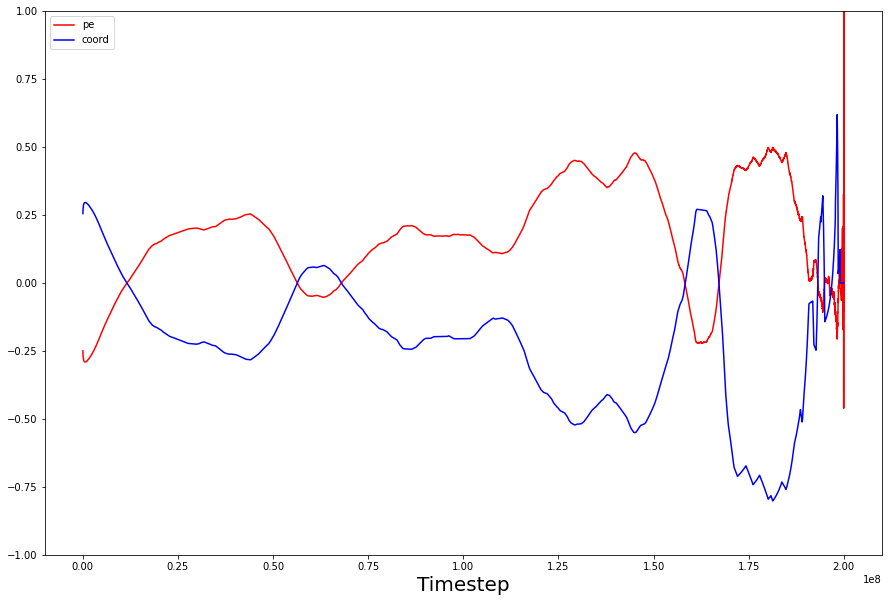

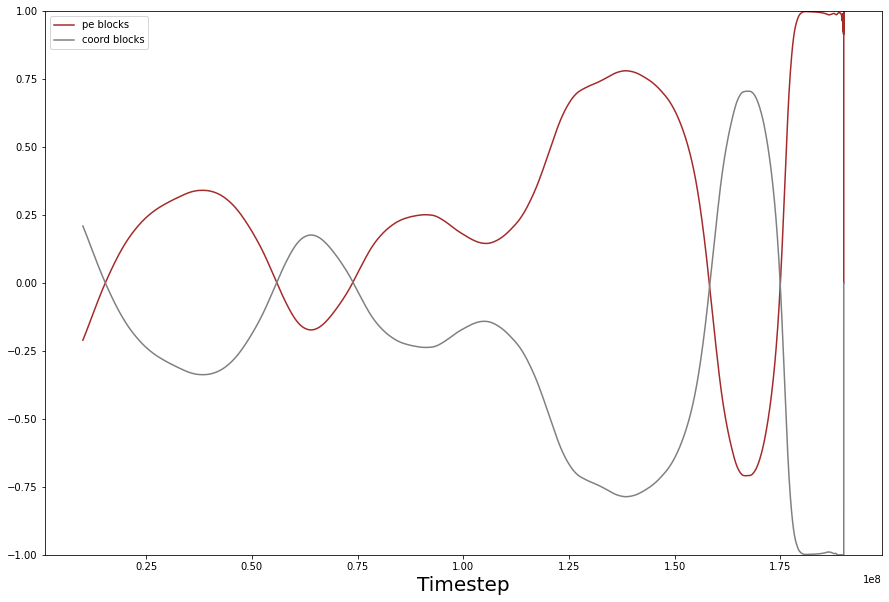

In [95]:
'''Leg 2: Case 1 BF check'''


# r to the end: raw
fig, ax = plt.subplots(figsize=[15, 10])
ax.set_xlabel("Timestep", fontsize=20)
ax.set_ylim(-1,1)

# PE
pe_rs = []
for step in steps:
    _, _, r_value, _, _ = scipy.stats.linregress(np.delete(timesteps, steps[:step]), np.delete(pe, steps[:step]))
    pe_rs.append(r_value)
ax.plot(timesteps, pe_rs, label="pe", color="red", linestyle="solid")
# Coord
coord_rs = []
for step in steps:
    _, _, r_value, _, _ = scipy.stats.linregress(np.delete(timesteps, steps[:step]), np.delete(coord, steps[:step]))
    coord_rs.append(r_value)
ax.plot(timesteps, coord_rs, label="coord", color="blue", linestyle="solid")
plt.savefig("figures/ebind%d/leg2.png" % E_BIND, bbox_inches="tight")
plt.legend(loc="upper left")
plt.show()


# r to the end: blocks
fig, ax = plt.subplots(figsize=[15, 10])
ax.set_xlabel("Timestep", fontsize=20)
ax.set_ylim(-1,1)

block_steps = [i for i in range(len(timesteps_raw))]

# PE
pe_rs_b = []
for block_step in block_steps:
    _, _, r_value, _, _ = scipy.stats.linregress(np.delete(timesteps_raw, block_steps[:block_step]), 
                                                 np.delete(pe_avgs, block_steps[:block_step])) 
    pe_rs_b.append(r_value)
ax.plot(timesteps_raw, pe_rs_b, label="pe blocks", color="brown", linestyle="solid")
# Coord
coord_rs_b = []
for block_step in block_steps:
    _, _, r_value, _, _ = scipy.stats.linregress(np.delete(timesteps_raw, block_steps[:block_step]), 
                                                 np.delete(coord_avgs, block_steps[:block_step]))
    coord_rs_b.append(r_value)
ax.plot(timesteps_raw, coord_rs_b, label="coord blocks", color="grey", linestyle="solid")

plt.legend(loc="upper left")
plt.show()


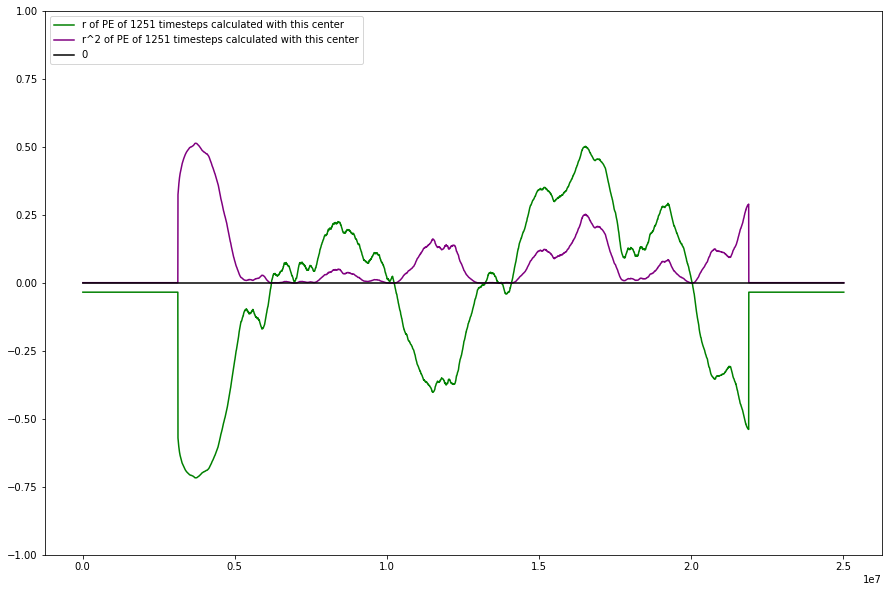

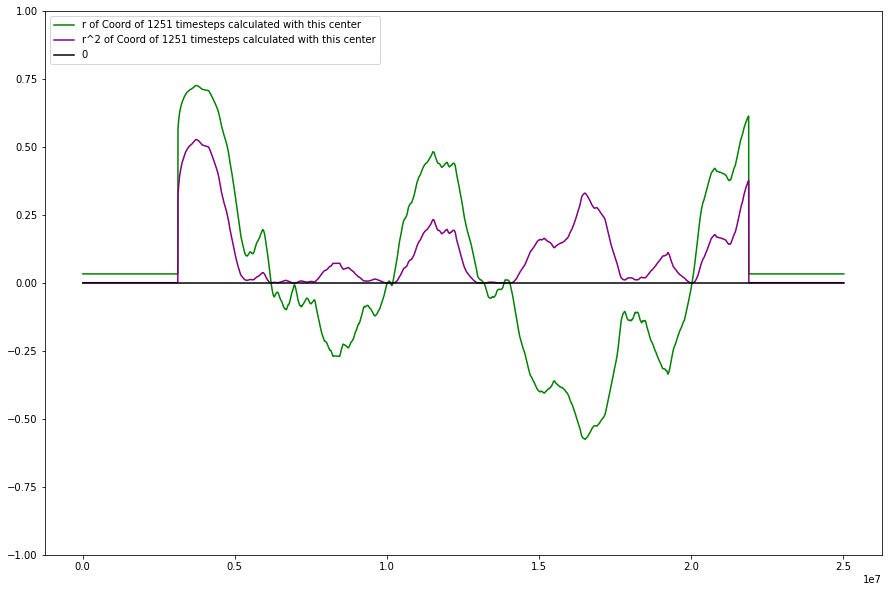

In [100]:
'''Leg 3: Case 2 sensing'''


block_width = (len(thermo_data["timestep"])-1)/4 + 1

# Block stats: 1/4 r
pe_avgs, pe_rs, timesteps_raw = util.plot_block_stats("ebind", block_width, pe, timesteps, "PE_fourth-", E_BIND, 
                                                      avgs_on=False, rs_on=True)
coord_avgs, coord_rs, _ = util.plot_block_stats("ebind", block_width, coord, timesteps, "coord_fourth-", E_BIND, 
                                                avgs_on=False, rs_on=True)


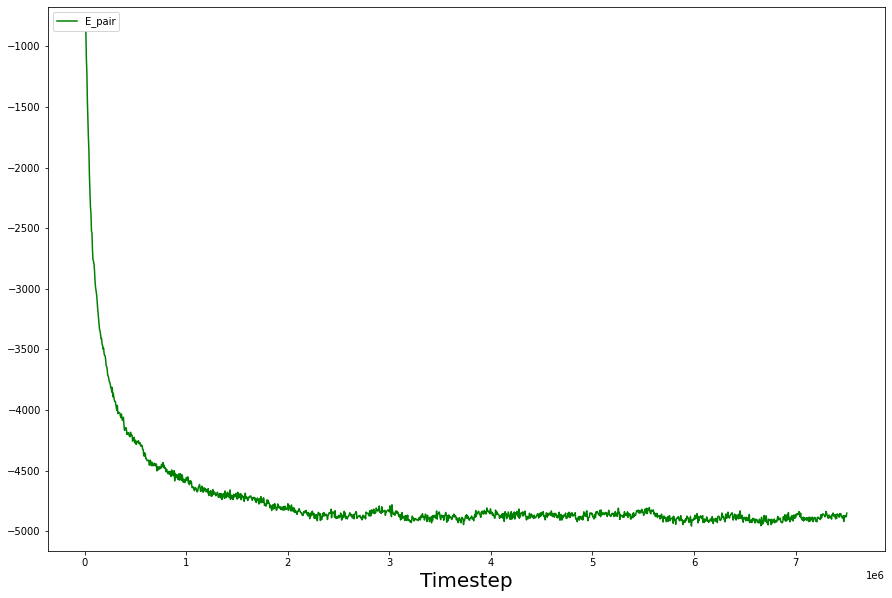

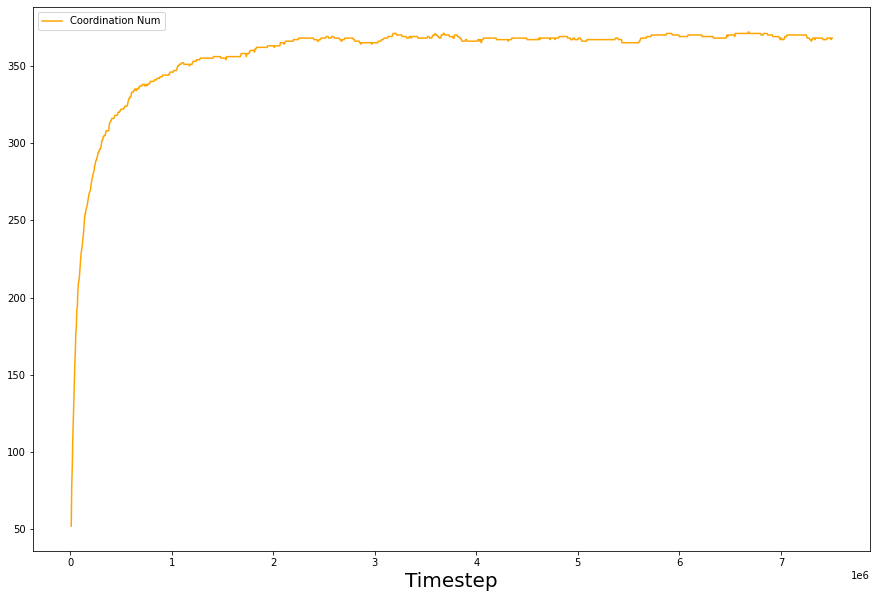

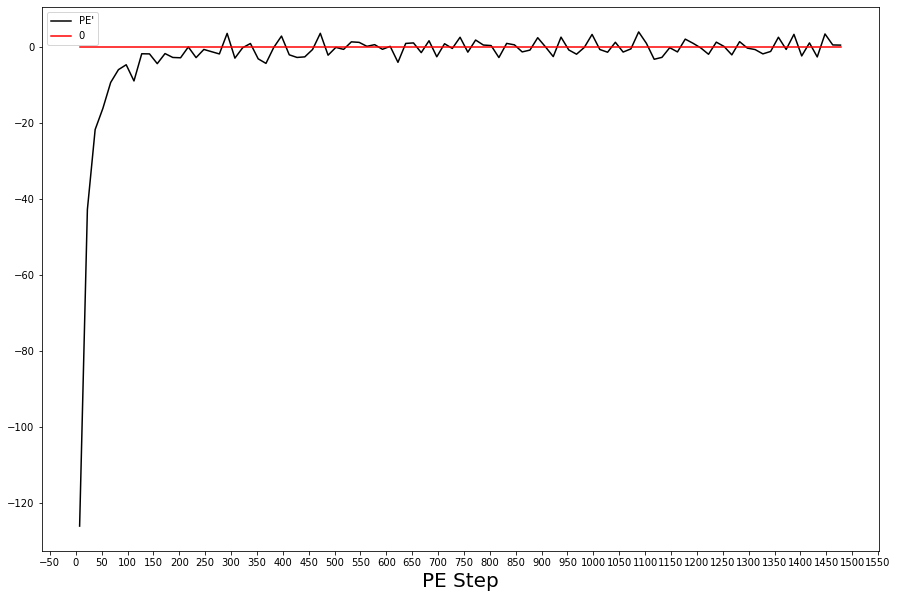

[[ 217.31695508]
 [ 217.68580427]
 [ 282.5060868 ]
 [ 300.7962434 ]
 [ 324.75590059]
 [ 340.98670843]
 [ 383.02310299]
 [ 406.31797289]
 [ 459.74971181]
 [ 481.94183609]
 [ 522.06805416]
 [ 585.30877622]
 [ 603.7433295 ]
 [ 608.19962181]
 [ 634.59903364]
 [ 658.93946356]
 [ 674.49371449]
 [ 688.42533575]
 [ 708.65113433]
 [ 723.17015299]
 [ 729.32307233]
 [ 752.39151403]
 [ 763.78161776]
 [ 804.38795478]
 [ 828.59716774]
 [ 852.25707298]
 [ 881.14440255]
 [ 907.81314441]
 [ 929.84505335]
 [ 949.15263308]
 [ 982.89284274]
 [1010.08490579]
 [1035.24857195]
 [1049.87367698]
 [1074.09519472]
 [1106.01355157]
 [1168.17522543]
 [1204.82395247]
 [1231.39838693]
 [1253.61353968]
 [1276.34631244]
 [1295.10289173]
 [1347.10237668]
 [1369.60251897]
 [1374.84326452]
 [1396.35261174]
 [1412.68846832]
 [1421.96434375]
 [1438.9330764 ]]


In [83]:
### STEP 2: CALCULATE TIME TO EQ


zoom = 0.3
fatness = 15

length = len(timesteps)
assert len(timesteps) == len(thermo_data["E_pair"])
assert len(thermo_data["E_pair"]) == len(coords_data["c_coords"])

timesteps_zmd = timesteps[:int(length*zoom)]
pe_zmd = thermo_data["E_pair"][:int(length*zoom)]
coords_zmd = coords_data["c_coords"][:int(length*zoom)]
steps_zmd = steps[:int(length*zoom)]

# Plot e_pair
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timesteps_zmd, pe_zmd, label="E_pair", color="green", linestyle="solid")
ax.set_xlabel("Timestep", fontsize=20)
plt.legend(loc="upper left")
plt.show()
# Plot coord number
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timesteps_zmd, coords_zmd, label="Coordination Num", color="orange", linestyle="solid")
ax.set_xlabel("Timestep", fontsize=20)
plt.legend(loc="upper left")
plt.show()


# Fat derivatives method

# Initial xlist and ylist: full versions of PE zoomed vs. steps zoomed
# Reduce both xlist and ylist, i.e. each step is now [fatness] wide instead of one step
fat_pe = []
fat_pe_steps = []
for idx, step in enumerate(steps_zmd):
    if idx % fatness == 0:
        fat_pe_steps.append(step)
        fat_pe.append(pe_zmd[idx])
x_prime, y_prime = util.num_derivative(fat_pe_steps, fat_pe)

# Plotting
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(x_prime, y_prime, label="PE'", color="black", linestyle="solid")
ax.plot(x_prime, [0]*len(y_prime), label="0", color="red", linestyle="solid")
ax.set_xlabel("PE Step", fontsize=20)
plt.locator_params(axis='x', nbins=50)
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/PE_deriv.png" % E_BIND, bbox_inches="tight")
plt.show()

# numerical intersections
x  = x_prime
y1 = y_prime
y2 = np.array([0]*len(y_prime))
xcs, _ = util.find_intercepts(x, y1, y2)

print(xcs)


approx eq2 point is  2935000  which is at step  585
Average PE: -4873.316725634058
Average Coordination Number: 367.92278079710144
std=2.1102493909290807
distribution:  [365 365 365 ... 369 369 368]
time distribution:  [ 2935000  2940000  2945000 ... 25000000 25005000 25010000]


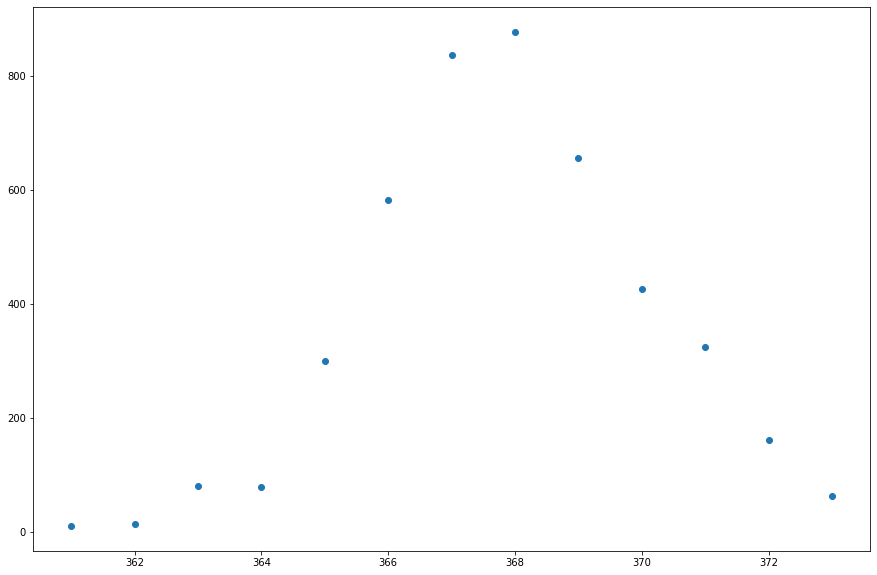

In [84]:
eq2_point = 585  # an index, the first point counted in the eq interval


timesteps = thermo_data["timestep"]
pe = thermo_data["E_pair"]
pe_steps = [i for i in range(len(pe))]
coord = coords_data["c_coords"]
assert len(pe) == len(coord)
coord_steps = [i for i in range(len(coord))]


'''Calculate using 2nd EQ point'''


# Key outputs
eq2_time = timesteps[eq2_point]
print("approx eq2 point is ", str(eq2_time), " which is at step ", str(eq2_point))

pe_eq = np.delete(pe, pe_steps[:eq2_point])
avg_pe = np.average(pe_eq)
print("Average PE: " + str(avg_pe))

coord_eq = np.delete(coord, pe_steps[:eq2_point])
avg_coord = np.average(coord_eq)
print("Average Coordination Number: " + str(avg_coord))

# Uncertainty
std = np.std(coord_eq, ddof=1)
print("std=" + str(std))

import csv
print("distribution: ", coord_eq)
print("time distribution: ", np.delete(timesteps, pe_steps[:eq2_point]))
with open('out/ebind%d/coord_distr.dat' % E_BIND, 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(zip(np.delete(timesteps, pe_steps[:eq2_point]),coord_eq))

    
#Test Normality of the distribution of coordination number after equilibrium
x_range = np.linspace(min(coord_eq), max(coord_eq), num= max(coord_eq) - min(coord_eq) +1)
counts = []
for x in x_range:
    count = 0
    for num in coord_eq:
        if num == x:
            count += 1
    counts.append(count)
fig, ax = plt.subplots(figsize=[15, 10])
ax.scatter(x_range, counts)
plt.show()


with open("out/ebind%d/out.txt" % E_BIND, "w") as text_file:
    text_file.write("approx eq2 point is " + str(eq2_time) + " which is at step " + str(eq2_point) + "\n")
    text_file.write("Average PE: " + str(avg_pe) + "\n")
    text_file.write("Average Coordination Number: " + str(avg_coord) + "\n")
    text_file.write("\n" + "std=" + str(std) + "\n")
    text_file.write("distribution: ")
    text_file.write(str(coord_eq))
    text_file.write(str(np.delete(timesteps, pe_steps[:eq2_point])))


OLD CODE


Block average, centered around step
PE
half_block = int(0.5*(block_width-1))
avg_pes = []
sigma_pes = []
r_pes = []
step_range = range(len(pe))[half_block:-half_block]
for step in step_range:
    pe_block = pe[step-half_block:step+half_block+1]
    avg_pe = np.average(pe_block)
    avg_pes.append(avg_pe)
    sigma_pes.append(np.std(pe_block, ddof=1))
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        timesteps[step-half_block:step+half_block+1], pe_block)
    r_pes.append(r_value)
timestep_range = [timesteps[i] for i in step_range]
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep_range, avg_pes, label="Average PE of %d timesteps calculated with this center" % block_width, 
        color="black", linestyle="solid")
ax.set_xlabel("Timesteps", fontsize=20)
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/PE_avg_block.png" % E_BIND, bbox_inches="tight")
plt.show()
Coord
avg_coords = []
sigma_coords = []
for step in step_range:
    coord_block = coord[step-half_block:step+half_block+1]
    avg_coord = np.average(coord_block)
    avg_coords.append(avg_coord)
    sigma_coords.append(np.std(coord_block, ddof=1))
timestep_range = [timesteps[i] for i in step_range]
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep_range, avg_coords, label="Average Coord # of %d timesteps calculated with this center" % 
        block_width, 
        color="black", linestyle="solid")
ax.set_xlabel("Timesteps", fontsize=20)
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/Coord_avg_block.png" % E_BIND, bbox_inches="tight")
plt.show()
Sigmas
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep_range, sigma_pes, label="Sigma of PE of %d timesteps calculated with this center" % block_width, 
        color="blue", linestyle="solid")
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/sigmas_coord_pe_block.png" % E_BIND, bbox_inches="tight")
plt.show()
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep_range, sigma_coords, label="Sigma of Coords of %d timesteps calculated with this center" % 
        block_width, color="red", linestyle="solid")
plt.legend(loc="upper left")
plt.savefig("figures/ebind%d/sigmas_coord_pe_block.png" % E_BIND, bbox_inches="tight")
plt.show()

In [ ]:
'''Pull in data -- 5mil'''


E_BIND = 16

# Pull in coords.dmp
dmp = "../sims_out/ebind/5mil/ebind%d/coords.dmp" % E_BIND
coords_dat = "out/ebind%d/coords.dat" % E_BIND
tot_lns = 10011
lns_per_time = 10
bad_lns = 9
tsteps_on = True
first_tstep = 10000
last_tstep = 5010000
tstep_size = 5000
cols = {
    0: "c_coords"
}
coords_data = util.dmp_to_dat(dmp, coords_dat, tot_lns, lns_per_time, bad_lns, cols, tsteps_on=tsteps_on, first_tstep=
                         first_tstep, last_tstep=last_tstep, tstep_size=tstep_size)
# Pull in log.lammps
thermo = "../sims_out/ebind/5mil/ebind%d/log.lammps" % E_BIND
thermo_dat = "out/ebind%d/thermo.dat" % E_BIND
header_len = 229
last_ln = 1230
tot_len = 1262
first_tstep = 10000
last_tstep = 5010000
tstep_size = 5000
cols = {  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",  
    5: "Press"
}
thermo_data = util.thermo_to_dat(thermo, thermo_dat, header_len, last_ln, tot_len, cols, first_tstep, last_tstep, 
                                 tstep_size)
#Hacky -- lazy, so just converting these to dictionaries since everything was written for this
# Convert to dictionary of numpy arrays:
thermo_data = thermo_data.to_dict("series")
for key in thermo_data:
    thermo_data[key] = np.array(thermo_data[key].values)
coords_data = coords_data.to_dict("series")
for key in coords_data:
    coords_data[key] = np.array(coords_data[key].values)

print("Number of timesteps: ", len(thermo_data["timestep"]))


In [ ]:
'''Pull in data -- 25mil'''


E_BIND = 8

# Pull in coords.dmp
dmp = "../sims_out/ebind/25mil/ebind%d/coords.dmp" % E_BIND
coords_dat = "out/ebind%d/coords.dat" % E_BIND
tot_lns = 50011
lns_per_time = 10
bad_lns = 9
tsteps_on = True
first_tstep = 10000
last_tstep = 25010000
tstep_size = 5000
cols = {
    0: "c_coords"
}
coords_data = util.dmp_to_dat(dmp, coords_dat, tot_lns, lns_per_time, bad_lns, cols, tsteps_on=tsteps_on, first_tstep=
                         first_tstep, last_tstep=last_tstep, tstep_size=tstep_size)
# Pull in log.lammps
thermo = "../sims_out/ebind/25mil/ebind%d/log.lammps" % E_BIND
thermo_dat = "out/ebind%d/thermo.dat" % E_BIND
header_len = 246
last_ln = 5247
tot_len = 5279
first_tstep = 10000
last_tstep = 25010000
tstep_size = 5000
cols = {  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",  
    5: "Press"
}
thermo_data = util.thermo_to_dat(thermo, thermo_dat, header_len, last_ln, tot_len, cols, first_tstep, last_tstep, 
                                 tstep_size)
#Hacky -- lazy, so just converting these to dictionaries since everything was written for this
# Convert to dictionary of numpy arrays:
thermo_data = thermo_data.to_dict("series")
for key in thermo_data:
    thermo_data[key] = np.array(thermo_data[key].values)
coords_data = coords_data.to_dict("series")
for key in coords_data:
    coords_data[key] = np.array(coords_data[key].values)

print("Number of timesteps: ", len(thermo_data["timestep"]))


In [ ]:
'''Pull in data -- extended'''


E_BIND = 16
sim_len = 200

# Pull in coords.dmp
dmp = "../sims_out/ebind/extended/ebind%d_%dmil/coords.dmp" % (E_BIND, sim_len)
coords_dat = "out/ebind%d/coords.dat" % E_BIND
tot_lns = sim_len*2*1000+11
lns_per_time = 10
bad_lns = 9
tsteps_on = True
first_tstep = 10000
last_tstep = sim_len*1000000+10000
tstep_size = 5000
cols = {
    0: "c_coords"
}
coords_data = util.dmp_to_dat(dmp, coords_dat, tot_lns, lns_per_time, bad_lns, cols, tsteps_on=tsteps_on, first_tstep=
                         first_tstep, last_tstep=last_tstep, tstep_size=tstep_size)
# Pull in log.lammps
thermo = "../sims_out/ebind/extended/ebind%d_%dmil/log.lammps" % (E_BIND, sim_len)
thermo_dat = "out/ebind%d/thermo.dat" % E_BIND
header_len = 233
# last_ln = sim_len*2*100+266 - 32
# tot_len = sim_len*2*100+266
last_ln = 40234
tot_len = 40266
first_tstep = 10000
last_tstep = 200010000
tstep_size = 5000
cols = {  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",          
    5: "Press"

}
thermo_data = util.thermo_to_dat(thermo, thermo_dat, header_len, last_ln, tot_len, cols, first_tstep, last_tstep, 
                                 tstep_size)
#Hacky -- lazy, so just converting these to dictionaries since everything was written for this
# Convert to dictionary of numpy arrays:
thermo_data = thermo_data.to_dict("series")
for key in thermo_data:
    thermo_data[key] = np.array(thermo_data[key].values)
coords_data = coords_data.to_dict("series")
for key in coords_data:
    coords_data[key] = np.array(coords_data[key].values)

# Reduce size
reduce_size = False
div = 8
if reduce_size:
    for key in thermo_data:
        og_array = thermo_data[key]
        new_list = []
        for idx, element in enumerate(og_array):
                if idx % div == 0:
                    new_list.append(element)

        thermo_data[key] = np.array(new_list)
    for key in coords_data:
        og_array = coords_data[key]
        new_list = []
        for idx, element in enumerate(og_array):
                if idx % div == 0:
                    new_list.append(element)

        coords_data[key] = np.array(new_list)

print("Number of timesteps: ", len(thermo_data["timestep"]))


In [32]:
'''Pull in data -- long/broken'''


E_BIND = 16
sim_len = 50

# Pull in coords.dmp
dmp = "../sims_out/ebind/trash/long/ebind%d_%dmil/coords.dmp" % (E_BIND, sim_len)
coords_dat = "out/ebind%d/coords.dat" % E_BIND
tot_lns = 10001
lns_per_time = 10
bad_lns = 9
tsteps_on = True
first_tstep = sim_len*1000
last_tstep = sim_len*1000000
tstep_size = sim_len*1000
cols = {
    0: "c_coords"
}
coords_data = util.dmp_to_dat(dmp, coords_dat, tot_lns, lns_per_time, bad_lns, cols, tsteps_on=tsteps_on, first_tstep=
                         first_tstep, last_tstep=last_tstep, tstep_size=tstep_size)
# Pull in log.lammps
thermo = "../sims_out/ebind/trash/long/ebind%d_%dmil/log.lammps" % (E_BIND, sim_len)
thermo_dat = "out/ebind%d/thermo.dat" % E_BIND
header_len = 230
last_ln = 1230
tot_len = 1263
first_tstep = sim_len*1000
last_tstep = sim_len*1000000
tstep_size = sim_len*1000
cols = {  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",  
    5: "Press"
}
thermo_data = util.thermo_to_dat(thermo, thermo_dat, header_len, last_ln, tot_len, cols, first_tstep, last_tstep, 
                                 tstep_size)
#Hacky -- lazy, so just converting these to dictionaries since everything was written for this
# Convert to dictionary of numpy arrays:
thermo_data = thermo_data.to_dict("series")
for key in thermo_data:
    thermo_data[key] = np.array(thermo_data[key].values)
coords_data = coords_data.to_dict("series")
for key in coords_data:
    coords_data[key] = np.array(coords_data[key].values)

# # Broken code
# for key in thermo_data:
#     og_array = thermo_data[key]
#     new_list = []
#     for idx, element in enumerate(og_array):
#             if idx % 5 == 3:
#                 new_list.append(element)
                
#     thermo_data[key] = np.array(new_list)


print("Number of timesteps: ", len(thermo_data["timestep"]))

Number of timesteps:  1000


In [ ]:
# more old code, this stuff is actually good

def r_interval(x, y, start, stop):
    if stop is not None:
        cut_y, cut_x = list(y)[start:stop], list(x)[start:stop]
    else:
        cut_y, cut_x = list(y)[start:], list(x)[start:]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                cut_x, cut_y)
    
    return r_value




# Correlation tester
eq2_guess = 500
pe_eq_guess = np.delete(pe, pe_steps[:eq2_guess])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            timesteps[eq2_guess:], pe_eq_guess)
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timesteps[eq2_guess:], pe_eq_guess, color="black", linestyle="solid")
plt.show()

print("r of whole eq, raw", r_value)
print(r_interval(timesteps, pe, eq2_guess, None))


eq2_time_guess = timesteps[eq2_guess]
eq2_guess_idx = timesteps_raw.index(eq2_time_guess)
block_steps = [i for i in range(len(timesteps_raw))]
pe_eq_guess_blocks = np.delete(pe_avgs, block_steps[:eq2_guess_idx])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            timesteps_raw[eq2_guess_idx:], pe_eq_guess_blocks)
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timesteps_raw[eq2_guess_idx:], pe_eq_guess_blocks, color="black", linestyle="solid")
plt.show()

print("r of whole eq, block", r_value)
print(r_interval(timesteps_raw, pe_avgs, eq2_guess_idx, None))